In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold, RepeatedKFold
from scipy import sparse
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
#显示所有列
pd.set_option('display.max_columns', None)
#显示所有行
pd.set_option('display.max_rows', None)
from datetime import datetime
def hour_cut(x):
    if 0<=x<6:
        return 0
    elif  6<=x<8:
        return 1
    elif  8<=x<12:
        return 2
    elif  12<=x<14:
        return 3
    elif  14<=x<18:
        return 4
    elif  18<=x<21:
        return 5
    elif  21<=x<24:
        return 6

#出生的年代
def birth_split(x):
    if 1920<=x<=1930:
        return 0
    elif  1930<x<=1940:
        return 1
    elif  1940<x<=1950:
        return 2
    elif  1950<x<=1960:
        return 3
    elif  1960<x<=1970:
        return 4
    elif  1970<x<=1980:
        return 5
    elif  1980<x<=1990:
        return 6
    elif  1990<x<=2000:
        return 7
    else:
        return 8
#收入分组
def income_cut(x):
    if x<0:
        return 0
    elif  0<=x<1200:
        return 1
    elif  1200<x<=10000:
        return 2
    elif  10000<x<24000:
        return 3
    elif  24000<x<40000:
        return 4
    elif  40000<=x:
        return 5
    else:
        return 6

In [4]:
drop_unlabeled = False
# preprocess_data_dir = Path('preprocess_data.ipynb').parent / 'split_data'
# preprocess_data_dir.mkdir(parents=True, exist_ok=True)
#导入数据
train=pd.read_csv("split_data/xy_train.csv",encoding='ISO-8859-1')
test=pd.read_csv("split_data/xy_test.csv",encoding='ISO-8859-1')

In [5]:
if drop_unlabeled:
    # y_train_ = y_train_.loc[y_train_ != -8]
    train = train.loc[train['happiness'] != -8]
else:
    train['happiness'] = train['happiness'].map(lambda x: 3 if x == -8 else x)
    test['happiness'] = test['happiness'].map(lambda x: 3 if x == -8 else x)

In [6]:
# 一起预处理
data = pd.concat([train, test], axis=0, ignore_index=True)
data = data.select_dtypes(include=[np.number])
correlation_matrix = data.corr()
# correlation_matrix.style.background_gradient(cmap='coolwarm')


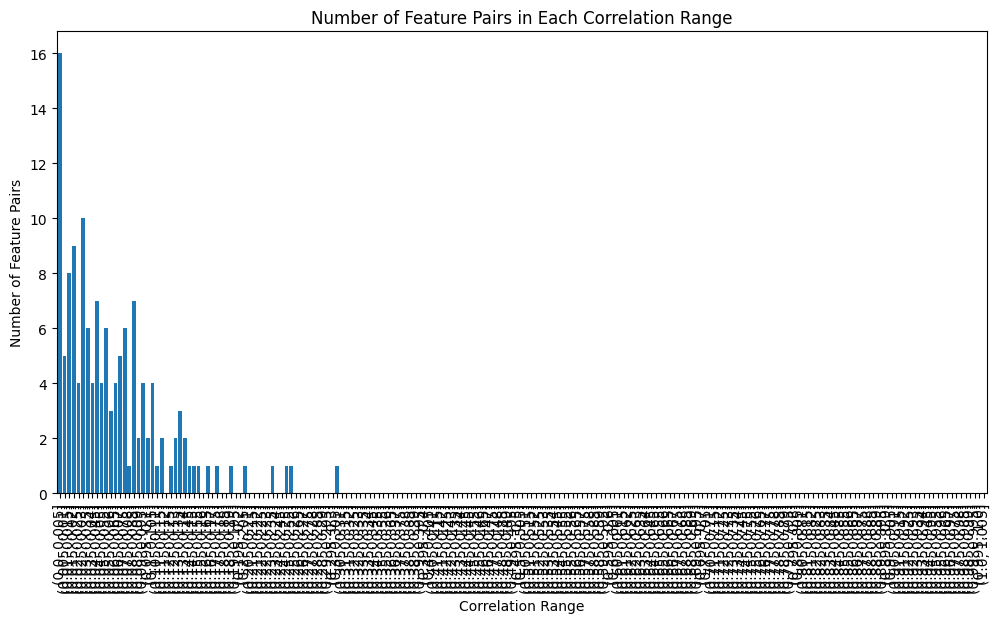

Cumulative counts up to 0-0.01: 21
Cumulative counts up to 0-0.02: 38
Cumulative counts up to 0-0.03: 52
Cumulative counts up to 0-0.04: 62
Cumulative counts up to 0-0.05: 73
Cumulative counts up to 0-0.05: 82


In [7]:
correlation_with_happiness = data.corr()['happiness'].drop('happiness').abs()
# 定义区间范围
bins = np.arange(0, 1.01, 0.005)
counts = pd.cut(correlation_with_happiness, bins=bins).value_counts().sort_index()

# 绘制柱状图
plt.figure(figsize=(12, 6))
counts.plot(kind='bar', width=0.8)
plt.xlabel("Correlation Range")
plt.ylabel("Number of Feature Pairs")
plt.title("Number of Feature Pairs in Each Correlation Range")
plt.xticks(rotation=90)
plt.show()
# 计算累积和
cumulative_counts = counts.cumsum()

# 输出累积特征数量在0-0.01，0-0.02，0-0.03等范围内的值
print("Cumulative counts up to 0-0.01:", cumulative_counts.loc[[0.01]].values[0])
print("Cumulative counts up to 0-0.02:", cumulative_counts.loc[[0.02]].values[0])
print("Cumulative counts up to 0-0.03:", cumulative_counts.loc[[0.03]].values[0])
print("Cumulative counts up to 0-0.04:", cumulative_counts.loc[[0.04]].values[0])
print("Cumulative counts up to 0-0.05:", cumulative_counts.loc[[0.05]].values[0])
print("Cumulative counts up to 0-0.05:", cumulative_counts.loc[[0.06]].values[0])

In [8]:
features = correlation_matrix['happiness'][abs(correlation_matrix['happiness']) > 0.005].index 
features = features.values.tolist()
# features.remove('happiness')
print(len(features))

124


In [9]:
xy_train = data[:train.shape[0]][features]
xy_test = data[train.shape[0]:][features]
xy_train.to_csv("split_data/xy_train_filtered_feature0.005.csv",index=False)
xy_test.to_csv("split_data/xy_test_filtered_feature0.005.csv",index=False)

In [10]:
# xy_train = data[:train.shape[0]][features]
# xy_test = data[train.shape[0]:][features]

In [11]:

# # 找出偏度大于 0.5 的字段
# skewed_features = xy_train.columns[xy_train.skew().abs() > 1]
# print("偏度大于 1 的字段:", skewed_features.tolist())
# print("偏度大于 1 的字段数量:", len(skewed_features))

# # 找出峰度大于 3 的字段
# kurtosis_features = xy_train.columns[xy_train.kurt() > 5]
# print("峰度大于 5 的字段:", kurtosis_features.tolist())
# print("峰度大于 5 的字段数量:", len(kurtosis_features))
# # 找出某些值占比超过 0.8 的字段
# high_frequency_features = []
# for col in xy_train.columns:
#     value_counts = xy_train[col].value_counts(normalize=True)
#     if any(value_counts > 0.8):
#         high_frequency_features.append(col)
# print("某些值占比超过 0.8 的字段:", high_frequency_features)

## 采样

In [16]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy={1: 1000, 2: 1000})
y_train = xy_train['happiness']
x_train = xy_train.drop(columns=['happiness'], axis=1)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

In [17]:
x_train_resampled['happiness'] = y_train_resampled
x_train_resampled.to_csv('split_data/xy_train_filtered_feature_resampled_smote.csv', index=False)

/var/folders/7r/g8ljr2nx79lcx_82d0zg_cc80000gn/T/ipykernel_21035/3453332216.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  x_train_resampled['happiness'] = y_train_resampled


In [18]:
from imblearn.over_sampling import ADASYN
y_train = xy_train['happiness']
x_train = xy_train.drop(["happiness"], axis=1)

# 假设X为特征，y为标签
adasyn = ADASYN(sampling_strategy='minority', random_state=42, n_neighbors=5)

# 进行ADASYN采样
X_resampled, y_resampled = adasyn.fit_resample(x_train,y_train)

X_resampled['happiness'] = y_resampled
X_resampled.to_csv('split_data/xy_train_filtered_feature_0.005_resampled_adasyn.csv', index=False)

/var/folders/7r/g8ljr2nx79lcx_82d0zg_cc80000gn/T/ipykernel_21035/3571778362.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_resampled['happiness'] = y_resampled


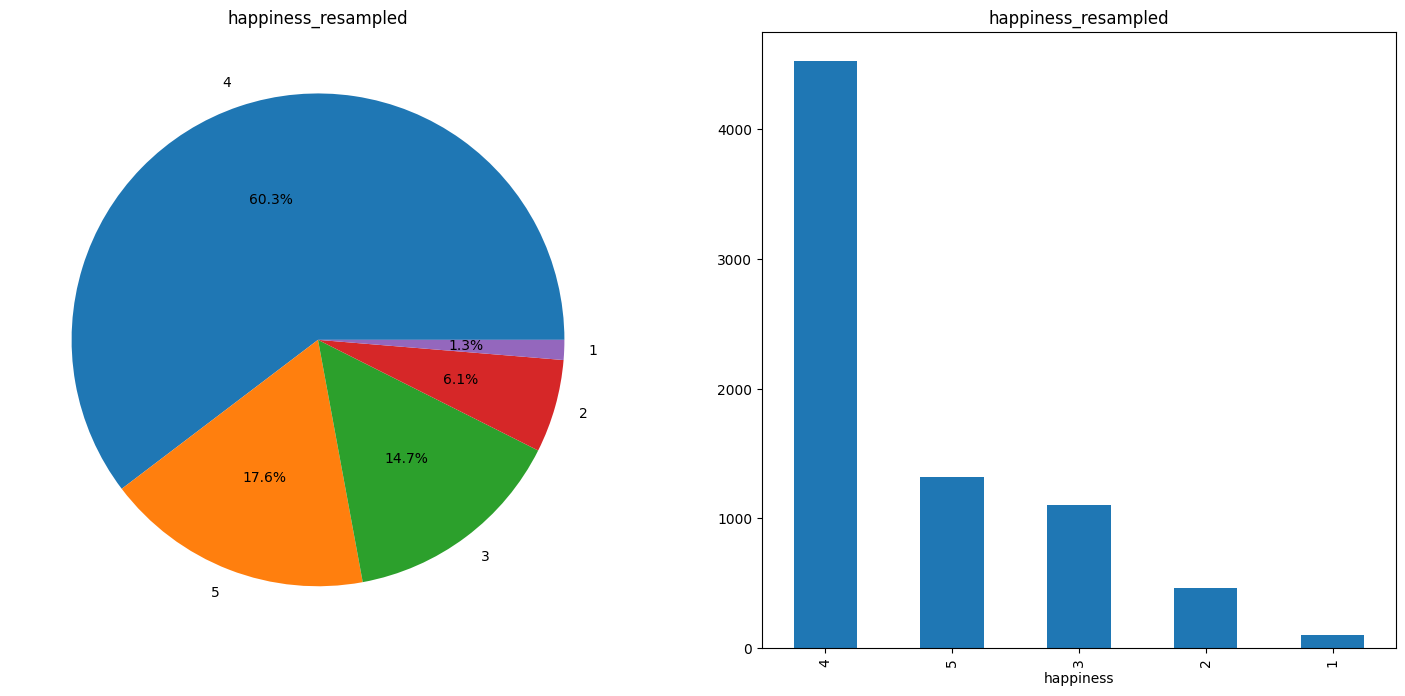

In [15]:
# 查看各个类别的分布情况 #
f,ax=plt.subplots(1,2,figsize=(18,8))
y_train.value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=False)
ax[0].set_title('happiness_resampled')
ax[0].set_ylabel('')
y_train.value_counts().plot.bar(ax=ax[1])
ax[1].set_title('happiness_resampled')
plt.show()
# plt.savefig(figirue_dir / 'happiness_distribution.png')